## Modeling

Kaggle Dataset at https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

Adapted by the creator from the 2020 annual CDC BRFSS survey data of 400k adults related to their health status to include heart disease indicators. Column details are in the data wrangling notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
import os
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from dython.nominal import associations, numerical_encoding, cluster_correlations
from dython.data_utils import split_hist

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, auc
from sklearn_evaluation import plot, table


In [2]:
sns.set_theme(style='whitegrid', palette='pastel')

In [3]:
data = pd.read_csv('../Capstone-Two/heartPHI2020.csv')
df = data.copy()
df.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Handling Imbalanced Data

After undersampling: Counter({'No': 27373, 'Yes': 27373})


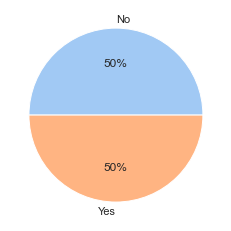

In [4]:
# Oversample and undersample and look at distributions.
# Undersample removes samples randomly from the majority class to make the distribution more equal
# As usual, X is all minus target variable
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_under, y_under = under_sampler.fit_resample(X, y)

# Count classes and create pie chart
print(f'After undersampling: {Counter(y_under)}')
plt.pie(y_under.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

After oversampling: Counter({'No': 292422, 'Yes': 292422})


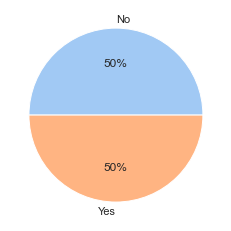

In [5]:
# oversampling randomly chooses and adds in samples from minority class to make distribution more equal
over_sampler = RandomOverSampler(sampling_strategy='minority', random_state=123)
X = df.iloc[:, 1:]
y = df['HeartDisease']
X_over, y_over = over_sampler.fit_resample(X, y)

print(f'After oversampling: {Counter(y_over)}')
plt.pie(y_over.value_counts(), labels = ['No', 'Yes'], autopct='%.0f%%');

In [6]:
# will move forward with undersampled df and explore oversampled df model performance later
y_under = pd.DataFrame(y_under)
undersampled_df = y_under.merge(X_under, left_index=True, right_index=True)
df = undersampled_df

## Preprocessing

In [7]:
# people with MentalHealth or PhysicalHealth response of 0, 
# responded that they had mental and physical problems 0 out of the last 30 days
df[['SleepTime', 'PhysicalHealth', 'MentalHealth']] = df[['SleepTime', 'PhysicalHealth', 'MentalHealth']].astype(int)

In [8]:
# similar to this study - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877313/
# will evaluate, BMI PhysicalHealth, MentalHealth, and SleepTime as both continuous and categorical variables
# they used these bins for SleepTime of ≤ 6 h, > 6 to < 9 h, ≥ 9 h
# MentalHealth and PhysicalHealth variables are responses to how many days in last 30-31 were bad for health
# binning them by week
# Underweight: Less than 18.5, Healthy: 18.5 to 24.9, Overweight: 25 to 29.9, Class I obesity: 30 to 34.9, Class II obesity: 35 to 39.9, Class III obesity: More than 40.

sleep_bins = [-np.inf, 5, 7, 9, np.inf]
sleep_labels = ['≤ 5', '> 5 to ≤ 7 h', '> 7 to ≤ 9 h', '> 9 h']
df['SleepTime_binned'] = pd.cut(df['SleepTime'], bins=sleep_bins, labels=sleep_labels)

bmi_bins = [-np.inf, 18.49, 24.9, 29.9, 34.9, 39.9, np.inf]
bmi_labels = ['Underweight','Healthy','Overweight', 'Class I Obesity', 'Class II Obesity', 'Class III Obesity']
df['BMI_binned'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels)

mental_bins = [-np.inf, 7, 14, 21, np.inf]
mental_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['MentalHealth_binned'] = pd.cut(df['MentalHealth'], bins=mental_bins, labels=mental_labels)

physical_bins = [-np.inf, 7, 14, 21, np.inf]
physical_labels = ['≤ 7 days','8-14 days','15-21 days', '> 21 days']
df['PhysicalHealth_binned'] = pd.cut(df['PhysicalHealth'], bins=physical_bins, labels=physical_labels)

re-bin with means?

In [9]:
agecat_mean = {'18-24':21,'25-29':27,'30-34':32,'35-39':37,'40-44':42,'45-49':47,'50-54':52,'55-59':57, 
                    '60-64':62,'65-69':67,'70-74':72,'75-79':77,'80 or older':80}

df['Mean_Age'] = df['AgeCategory'].apply(lambda x: agecat_mean[x])
df.drop(columns=['AgeCategory'],inplace=True)

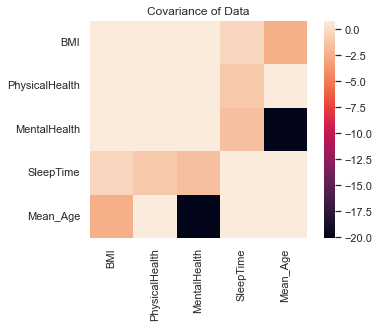

In [10]:
data_covariance = df.cov()
sns.heatmap(data_covariance, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

Encode and standardize data.

In [11]:
# label encode cols with 2 or less options
lencoder = LabelEncoder()
columns = ['Sex', 'HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 
           'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'PhysicalHealth']
for col in columns:
        df[col] = lencoder.fit_transform(df[col])
# onehot encode variables nunique > 2 -- model accuracies lower with onehot encoded 'AgeCategory'
df = pd.get_dummies(df, columns=['Race', 'Diabetic', 'GenHealth', 'SleepTime_binned', 'BMI_binned', 'MentalHealth_binned', 
                                 'PhysicalHealth_binned'], prefix=['Race', 'Diabetic', 'GenHealth', 'SleepTime_binned', 
                                                                   'BMI_binned', 'MentalHealth_binned', 'PhysicalHealth_binned'])


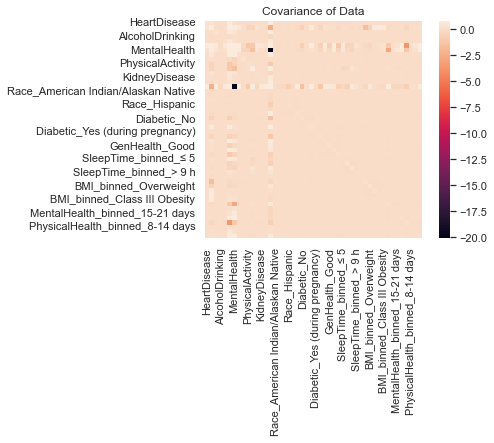

In [12]:
data_covariance = df.cov()
sns.heatmap(data_covariance, vmax=.8, square=True)
plt.title("Covariance of Data")
plt.show()

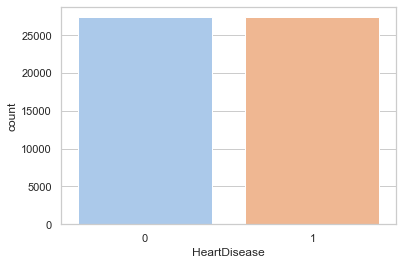

In [13]:
# train_test_split (before scaler)
X = df.iloc[:, 1:]
y = df['HeartDisease']

# confirm balance
sns.countplot(x=y, data=df)
plt.show()

In [14]:
len(X)

54746

In [15]:
df_corr = df.corr()['HeartDisease'].abs().sort_values(ascending=False)
df_corr

HeartDisease                           1.000000
Mean_Age                               0.441305
DiffWalking                            0.292866
Diabetic_Yes                           0.264561
Diabetic_No                            0.258449
GenHealth_Excellent                    0.246392
PhysicalHealth                         0.244809
PhysicalHealth_binned_≤ 7 days         0.236571
Stroke                                 0.232228
GenHealth_Fair                         0.217316
GenHealth_Poor                         0.209829
PhysicalHealth_binned_> 21 days        0.200893
Smoking                                0.191870
GenHealth_Very good                    0.191218
KidneyDisease                          0.184841
PhysicalActivity                       0.161174
SkinCancer                             0.140825
Sex                                    0.122945
BMI                                    0.094139
SleepTime_binned_> 5 to ≤ 7 h          0.091700
BMI_binned_Healthy                     0

In [16]:
# split data into train/test before scaling or tuning to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

Outliers

In [17]:
# outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

lof = LocalOutlierFactor(p=1, n_jobs=-1)
yhat = lof.fit_predict(X_train)
# select all rows that are not outliers -- -1 is outlier 
mask = yhat != -1
X_train, y_train = X_train.iloc[mask], y_train.iloc[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(38582, 47) (38582,)


In [18]:
num_removed = len(yhat) - np.count_nonzero(yhat==1)
num_removed

5214

Scaling

In [19]:
# separate numerical columns to be scaled
num_train_df = X_train[['BMI', 'PhysicalHealth','MentalHealth', 'SleepTime', 'Mean_Age']]
num_test_df = X_test[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age']]

# fit scaler on training data and only transform test data
# scale after train_test_split to avoid causing data leakage
scaler = RobustScaler()

X_train_num = scaler.fit(num_train_df)
X_train_num = scaler.transform(num_train_df)
X_test_num = scaler.transform(num_test_df)

# Add column names and convert to df
col_names = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age']
X_train_num = pd.DataFrame(X_train_num, columns=col_names)
X_test_num = pd.DataFrame(X_test_num, columns=col_names)

In [20]:
# merge cat and num dataframes
X_train = X_train.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age'])
X_train = X_train.reset_index(drop=True)
X_train = X_train.merge(X_train_num, left_index=True, right_index=True)

X_test = X_test.drop(columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'Mean_Age'])
X_test = X_test.reset_index(drop=True)
X_test = X_test.merge(X_test_num, left_index=True, right_index=True)

## Feature selection

Tested LassoCV, RidgeCV, RFECV, and models selection methods

In [21]:
# feature selection with lasso regularization 
alphas = np.arange(0.1,10,0.1)
lassocv = LassoCV(alphas=alphas, random_state = 45)
lassocv.fit(X_train, y_train)

print(f'lassocv coef > 0 : {np.sum(lassocv.coef_ > 0)}')
feature_names = lassocv.feature_names_in_[lassocv.coef_ > 0]
print(f'features with lassocv coef > 0: {feature_names}')
print(f'alpha: {lassocv.alpha_}')
lasso_mse_path = lassocv.mse_path_
print(f'num features in: {lassocv.n_features_in_}')
print(f'score: {lassocv.score(X_test,y_test)}')

lassocv coef > 0 : 2
features with lassocv coef > 0: ['PhysicalHealth' 'Mean_Age']
alpha: 0.1
num features in: 47
score: 0.17791620238805728


After substituting Mean_Age for AgeCategory, Lasso suggests 2 features: ['PhysicalHealth' 'Mean_Age']

## Feature groupings to test

In [22]:
# Mean_Age only
age_X_train = X_train[['Mean_Age']]
age_X_test = X_test[['Mean_Age']]

In [23]:
# lasso chosen features
lasso_X_train = X_train[['Mean_Age', 'PhysicalHealth']]
lasso_X_test = X_test[['Mean_Age', 'PhysicalHealth']]

In [25]:
# RFECV features
RFE_X_train = X_train[['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_Asian', 'Race_Black', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'BMI_binned_Healthy', 'BMI_binned_Class I Obesity',
       'MentalHealth_binned_≤ 7 days', 'PhysicalHealth_binned_≤ 7 days', 'BMI',
       'SleepTime', 'Mean_Age']]
RFE_X_test = X_test[['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Race_Asian', 'Race_Black', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Poor', 'GenHealth_Very good',
       'SleepTime_binned_> 5 to ≤ 7 h', 'SleepTime_binned_> 7 to ≤ 9 h',
       'BMI_binned_Healthy', 'BMI_binned_Class I Obesity',
       'MentalHealth_binned_≤ 7 days', 'PhysicalHealth_binned_≤ 7 days', 'BMI',
       'SleepTime', 'Mean_Age']]

Feature iterations to test from RFE -- 20 features, 25 features, then CV option

## Modeling

**begin testing**

In [27]:
## Test other models with feature selection 

**Logistic Regression**

In [28]:
# out of the box logistic regression model for benchmark
# starting off simple with a linear model - LogReg
lr = LogisticRegression(random_state=123, max_iter=300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('LogReg1 no penalty model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Classification report: \n{classification_report(y_test, y_pred, digits=5)}')

y_hat = lr.predict(X_train)
print(f'LogReg training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg test set accuracy: {accuracy_score(y_test, y_pred)}')

LogReg1 no penalty model: 

Confusion matrix: 
[[4193 1390]
 [1119 4248]]
Classification report: 
              precision    recall  f1-score   support

           0    0.78934   0.75103   0.76971      5583
           1    0.75346   0.79150   0.77201      5367

    accuracy                        0.77087     10950
   macro avg    0.77140   0.77127   0.77086     10950
weighted avg    0.77176   0.77087   0.77084     10950

LogReg training set accuracy: 0.7672489762065212
LogReg test set accuracy: 0.7708675799086758


In [29]:
# Logistic Regression with l1 regularization (Lasso) 
lr2 = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=StratifiedKFold(5), random_state=45, n_jobs=-1)
lr2 = lr2.fit(X_train, y_train)
y_pred2 = lr2.predict(X_test)

print('LogReg2 Lasso model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred2)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred2, digits=5)}')

# model evaluation against test set
y_hat = lr2.predict(X_train)
print(f'LogReg2 training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'LogReg2 test set accuracy: {accuracy_score(y_test, y_pred2)}')

LogReg2 Lasso model: 

Confusion matrix: 
[[4190 1393]
 [1108 4259]]

Classification report: 
              precision    recall  f1-score   support

           0    0.79086   0.75049   0.77015      5583
           1    0.75354   0.79355   0.77303      5367

    accuracy                        0.77160     10950
   macro avg    0.77220   0.77202   0.77159     10950
weighted avg    0.77257   0.77160   0.77156     10950

LogReg2 training set accuracy: 0.7674822456067596
LogReg2 test set accuracy: 0.7715981735159817


In [30]:
y_pred2_prob = lr2.predict_proba(X_test)
y_pred2_proba = [j for [i,j] in y_pred2_prob]

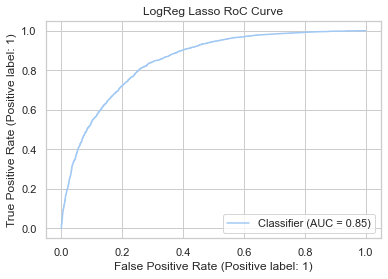

LogReg Lasso ROC-AUC: 0.848704198353482


In [31]:
# ROC-AUC curve
lr2_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred2_proba, pos_label=1)
plt.title("LogReg Lasso RoC Curve")
plt.show()
ras = roc_auc_score(y_test, y_pred2_proba)
print(f'LogReg Lasso ROC-AUC: {ras}')

**Mean_Age Only Log Reg**

In [32]:
# AGE ONLY Logistic Regression with l1 regularization (Lasso) 
lr2_age = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', scoring='accuracy', cv=StratifiedKFold(5), random_state=45, n_jobs=-1)
lr2_age = lr2_age.fit(age_X_train, y_train)
y_pred2_age = lr2_age.predict(age_X_test)

print('Mean_Age Only LogReg2 Lasso model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred2_age)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred2_age, digits=5)}')

# model evaluation against test set
y_hat_age = lr2_age.predict(age_X_train)
print(f'Mean_Age Only LogReg2 training set accuracy: {accuracy_score(y_train, y_hat_age)}')
print(f'Mean_Age Only LogReg2 test set accuracy: {accuracy_score(y_test, y_pred2_age)}')

Mean_Age Only LogReg2 Lasso model: 

Confusion matrix: 
[[3223 2360]
 [1086 4281]]

Classification report: 
              precision    recall  f1-score   support

           0    0.74797   0.57729   0.65164      5583
           1    0.64463   0.79765   0.71302      5367

    accuracy                        0.68530     10950
   macro avg    0.69630   0.68747   0.68233     10950
weighted avg    0.69732   0.68530   0.68173     10950

Mean_Age Only LogReg2 training set accuracy: 0.698019801980198
Mean_Age Only LogReg2 test set accuracy: 0.6852968036529681


PhysicalHealth, Mean_Age Only LogReg2 training set accuracy: 0.7251364053805845
PhysicalHealth, Mean_Age Only LogReg2 test set accuracy: 0.712054794520548

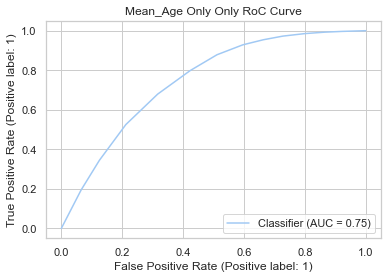

Mean_Age Only only ROC-AUC: 0.7473781420286857


In [33]:
y_pred2_age_prob = lr2_age.predict_proba(age_X_test)
y_pred2_age_proba = [j for [i,j] in y_pred2_age_prob]
age_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred2_age_proba)
plt.title("Mean_Age Only Only RoC Curve")
plt.show()

ras = roc_auc_score(y_test, y_pred2_age_proba)
print(f"Mean_Age Only only ROC-AUC: {ras}")

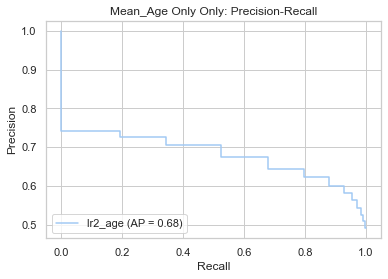

Mean_Age Only Only Precision-Recall AUC: 0.6804804775096305


In [34]:
average_precision = average_precision_score(y_test, y_pred2_age_proba, average="micro", pos_label=1)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred2_age_proba, pos_label=1)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name="lr2_age")
disp.plot()
plt.title("Mean_Age Only Only: Precision-Recall")
plt.show()
pr_auc = average_precision_score(y_test, y_pred2_age_proba, pos_label=1)
print(f"Mean_Age Only Only Precision-Recall AUC: {pr_auc}")

**LinearSVC**

In [37]:
from sklearn.calibration import CalibratedClassifierCV
lsvc_ = LinearSVC(random_state=123, max_iter=4000)
# CalibratedClassifierCV allows LinearSVC to give probablities, which otherwise does not
lsvc = CalibratedClassifierCV(lsvc_) 
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_test)

print('LinearSVC model: \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred_lsvc)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_lsvc, digits=5)}')

y_hat_lsvc = sgdc.predict(X_train)
print(f'LinearSVC training set accuracy: {accuracy_score(y_train, y_hat_lsvc)}')
print(f'LinearSVC test set accuracy: {accuracy_score(y_test, y_pred_lsvc)}')

LinearSVC model: 

Confusion matrix: 
[[4200 1383]
 [1135 4232]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78725   0.75228   0.76937      5583
           1    0.75370   0.78852   0.77072      5367

    accuracy                        0.77005     10950
   macro avg    0.77047   0.77040   0.77004     10950
weighted avg    0.77081   0.77005   0.77003     10950

LinearSVC training set accuracy: 0.7641127987144264
LinearSVC test set accuracy: 0.7700456621004567


In [38]:
y_pred_lsvc_prob = lsvc.predict_proba(X_test)
y_pred_lsvc_proba = [j for [i,j] in y_pred_lsvc_prob]

**KNN**

In [39]:
# randomizedsearch for knn params
grid_params = {'n_neighbors' : list(range(3,30)),
               'leaf_size' : list(range(1,50,2)),
               'p' : [1,2],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

rs = RandomizedSearchCV(KNeighborsClassifier(), grid_params, verbose=2, cv=5, n_jobs=-1, random_state=42)
rs_knn = rs.fit(X_train, y_train)

print(f'Best params: {rs_knn.best_params_}')
print(f'Best score: {rs_knn.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'weights': 'uniform', 'p': 1, 'n_neighbors': 29, 'metric': 'euclidean', 'leaf_size': 5}
Best score: 0.7506092834432783


In [40]:
# KNN model with GridSearchCV params
knn = KNeighborsClassifier(weights='uniform', p = 1, n_neighbors = 29, metric = 'euclidean', leaf_size = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('K Neighbors model \n')
print(f'Confusion matrix: \n{confusion_matrix(y_test, y_pred_knn)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_knn, digits=5)}')
# model evaluation against test set
y_hat = knn.predict(X_train)
print(f'KNN training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'KNN test set accuracy: {accuracy_score(y_test, y_pred_knn)}')

K Neighbors model 

Confusion matrix: 
[[3984 1599]
 [1104 4263]]

Classification report: 
              precision    recall  f1-score   support

           0    0.78302   0.71359   0.74670      5583
           1    0.72723   0.79430   0.75928      5367

    accuracy                        0.75315     10950
   macro avg    0.75512   0.75395   0.75299     10950
weighted avg    0.75567   0.75315   0.75287     10950

KNN training set accuracy: 0.7651754704266238
KNN test set accuracy: 0.7531506849315068


In [41]:
y_pred_knn_prob = knn.predict_proba(X_test)
y_pred_knn_proba = [j for [i,j] in y_pred_knn_prob]

**Random Forest**

In [42]:
grid_params = {'criterion' : ['gini', 'entropy'],
               'n_estimators' : list(range(1,500)),
               'max_depth': list(range(3, 20))}

rf_rs = RandomizedSearchCV(RandomForestClassifier(), grid_params, verbose=1, cv=5, n_jobs=-1)
rf = rf_rs.fit(X_train, y_train)

print(f'Best params: {rf.best_params_}')
print(f'Best score: {rf.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 281, 'max_depth': 16, 'criterion': 'entropy'}
Best score: 0.7661346096655449


In [43]:
# entropy Random Forest Classifier model, consider playing with max_depth. is that a hyperparameter?
rfc = RandomForestClassifier(criterion='entropy', n_estimators=362, max_depth=12, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print('Random Forest Entropy model \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_rfc)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_rfc, digits=5)}')

# model evaluation against test set
y_hat = rfc.predict(X_train)
print(f'Random Forest training set accuracy: {accuracy_score(y_train, y_hat)}')
print(f'Random Forest test set accuracy: {accuracy_score(y_test, y_pred_rfc)}')

Random Forest Entropy model 

Confusion matrix: 
 [[3987 1596]
 [ 961 4406]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80578   0.71413   0.75719      5583
           1    0.73409   0.82094   0.77509      5367

    accuracy                        0.76648     10950
   macro avg    0.76993   0.76754   0.76614     10950
weighted avg    0.77064   0.76648   0.76597     10950

Random Forest training set accuracy: 0.7975221605930226
Random Forest test set accuracy: 0.7664840182648401


In [44]:
y_pred_rfc_prob = rfc.predict_proba(X_test)
y_pred_rfc_proba = [j for [i,j] in y_pred_rfc_prob]

**XGB**

XGB RFECV chosen features:

Optimal number of features : 11
RFE selected features: 
Index(['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']

In [45]:
xgb_X_train = X_train[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good', 
                       'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]
xgb_X_test = X_test[['Stroke', 'DiffWalking', 'Sex', 'Diabetic_No', 'Diabetic_Yes',
                      'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
                      'GenHealth_Poor', 'GenHealth_Very good', 'Mean_Age']]

In [46]:
# XGB using selected XGB features
xgb2 = XGBClassifier(use_label_encoder=False, random_state=123)
xgb2 = xgb2.fit(xgb_X_train, y_train)
y_pred_xgb2 = xgb2.predict(xgb_X_test)

# evaluate xgb2 model
print('XGBoost model with Selected Features: \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test,y_pred_xgb2)}\n')
print(f'Classification report: \n{classification_report(y_test, y_pred_xgb2, digits=5)}')


# model evaluation against test set
xgb2_y_hat = xgb2.predict(xgb_X_train)
print(f'XGB2 training set accuracy: {accuracy_score(y_train, xgb2_y_hat)}')
print(f'XGB2 Forest test set accuracy: {accuracy_score(y_test, y_pred_xgb2)}')

[07:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model with Selected Features: 

Confusion matrix: 
 [[3954 1629]
 [ 968 4399]]

Classification report: 
              precision    recall  f1-score   support

           0    0.80333   0.70822   0.75278      5583
           1    0.72976   0.81964   0.77209      5367

    accuracy                        0.76283     10950
   macro avg    0.76655   0.76393   0.76244     10950
weighted avg    0.76727   0.76283   0.76225     10950

XGB2 training set accuracy: 0.7714478254108134
XGB2 Forest test set accuracy: 0.7628310502283105


In [47]:
y_pred_xgb2_prob = xgb2.predict_proba(xgb_X_test)
y_pred_xgb2_proba = [j for [i,j] in y_pred_xgb2_prob]

In [48]:
# Using XGB selected features limits overfitting on the training set and increases accuracy somewhat

## Model Evaluation

Compare precision-recall and ROC curves + AUC

In [49]:
# Log Reg
precision_lr2, recall_lr2, thresholds_lr2 = precision_recall_curve(y_test,
                                                                   y_pred2_proba,
                                                                   pos_label=1)
pr_auc_lr2 = auc(recall_lr2, precision_lr2)
# KNN
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, 
                                                                   y_pred_knn_proba,
                                                                   pos_label=1)
pr_auc_knn = auc(recall_knn, precision_knn)
# Random Forest
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, 
                                                                y_pred_rfc_proba,
                                                                pos_label=1)
pr_auc_rf = auc(recall_rf, precision_rf)
# XGB2
precision_xgb2, recall_xgb2, thresholds_xgb2 = precision_recall_curve(y_test, 
                                                                      y_pred_xgb2_proba,
                                                                      pos_label=1)
pr_auc_xgb2 = auc(recall_xgb2, precision_xgb2)
# LinearSVC
precision_lsvc, recall_lsvc, thresholds_lsvc = precision_recall_curve(y_test, 
                                                                      y_pred_lsvc_proba,
                                                                      pos_label=1)
pr_auc_lsvc = auc(recall_lsvc, precision_lsvc)


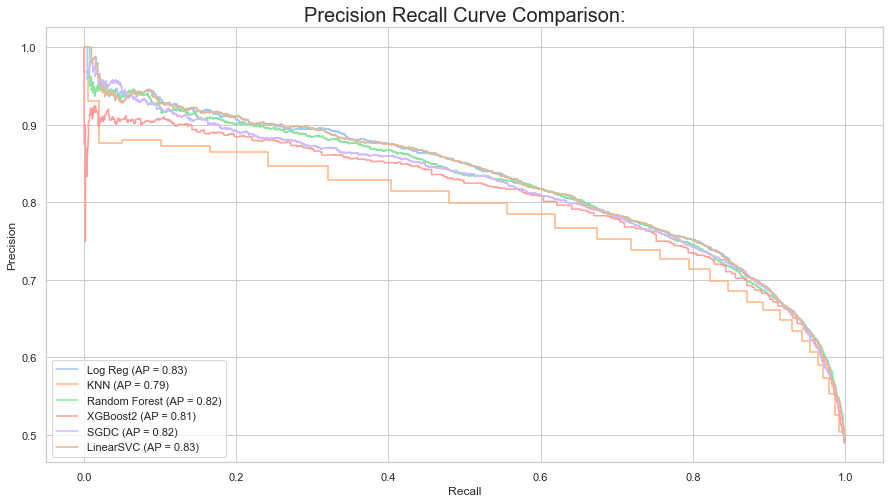

In [50]:
# plot precision-recall curve comparisons

fig, ax = plt.subplots(figsize=(15,8))
plt.title('Precision Recall Curve Comparison:', size=20)
# Log Reg
lr2_disp = PrecisionRecallDisplay(precision=precision_lr2, recall=recall_lr2, average_precision=pr_auc_lr2, estimator_name="Log Reg")
lr2_disp.plot(ax=ax)
# KNN
knn_disp = PrecisionRecallDisplay(precision=precision_knn, recall=recall_knn, average_precision=pr_auc_knn, estimator_name="KNN")
knn_disp.plot(ax=ax)
# Random Forest
rf_disp = PrecisionRecallDisplay(precision=precision_rf, recall=recall_rf, average_precision=pr_auc_rf, estimator_name="Random Forest")
rf_disp.plot(ax=ax)
# XGBoost2
xgb2_disp = PrecisionRecallDisplay(precision=precision_xgb2, recall=recall_xgb2, average_precision=pr_auc_xgb2, estimator_name="XGBoost2")
xgb2_disp.plot(ax=ax)
# LinearSVC
lsvc_disp = PrecisionRecallDisplay(precision=precision_lsvc, recall=recall_lsvc, average_precision=pr_auc_lsvc, estimator_name="LinearSVC")
lsvc_disp.plot(ax=ax)

plt.show()


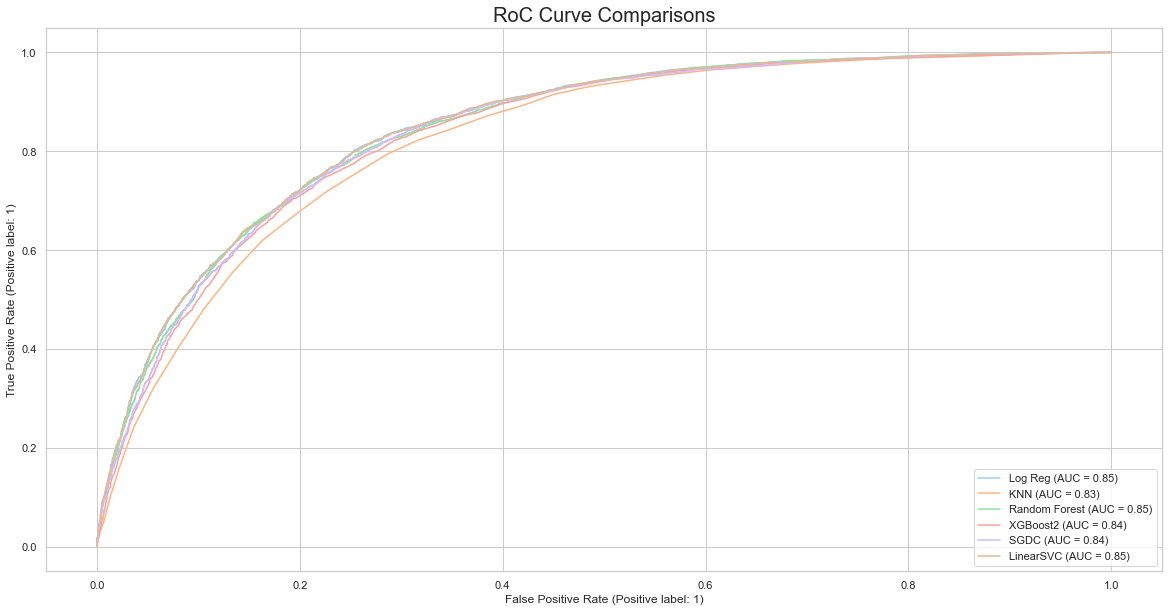

In [54]:
# ROC curves
fig, ax1 = plt.subplots(figsize=(20,10))
plt.title("RoC Curve Comparisons", size=20)

lr2_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred2_proba, pos_label=1, name='Log Reg', ax=ax1)
knn_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_knn_proba, pos_label=1, name='KNN', ax=ax1)
rf_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_rfc_proba, pos_label=1, name='Random Forest', ax=ax1)
xgb2_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_xgb2_proba, pos_label=1, name='XGBoost2', ax=ax1)
sgdc_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_sgdc_proba, pos_label=1, name='SGDC', ax=ax1)
lsvc_roc_pred = RocCurveDisplay.from_predictions(y_test, y_pred_lsvc_proba, pos_label=1, name='LinearSVC', ax=ax1)

plt.show()

## Conclusion

Though linear models have lower complexity in comparison to different types of black box models, that does not mean they produce the lowest accuracy scores from the same data. 

After trying a few different types of models and utilizing both GridSearchCV and RandomizedSearchCV for hyperparameter optimization, logistic regression model with L1 penalty is the most accurate model. 